<a href="https://colab.research.google.com/github/dmytro-varich/Texture-Segmentation-App/blob/main/segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Jacob Gildenblat, 2015
#Implementation of edge preserving smoothing by minimizing with the Ambrosio-Tortorelli appoach
#AM scheme, using conjugate gradients
import cv2, scipy
import numpy as np
import sys
import scipy
from scipy.sparse.linalg import LinearOperator

class AmbrosioTortorelliMinimizer():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01):
		self.iterations = iterations
		self.tol = tol
		self.g = np.float64(img) / np.max(img)
		self.f = self.g
		self.edges = np.zeros(img.shape)
		self.update_gradients()
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)

In [75]:
import os
from typing import Any, Union, Dict, Tuple, List
import imageio

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, data, exposure, transform, color, morphology
from skimage.filters.rank import entropy

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

import pydensecrf.densecrf as dcrf

In [97]:
class TextureSegmentation:

    @staticmethod
    def load_images(directory: str) -> dict:
        images = dict()
        for filename in os.listdir(directory):
            if not filename.endswith('.png'):
                continue
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
              image = io.imread(file_path)
              images[filename] = image
        return images

    @staticmethod
    def show_images(images: dict, rows: int, cols: int, cmap:str = None, show_ax: str = 'on') -> None:
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

        # В случае, если всего одна ось (например, rows=1, cols=1)
        if rows == 1 and cols == 1:
            axes = [axes]
        else:
          axes = axes.flatten()  # converting to 1dim array

        for ax, (title, image) in zip(axes, images.items()):
            img = image * 1
            cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
            img = np.uint8(img)
            ax.imshow(img, cmap=cmap)
            ax.set_title(title)
            ax.axis(show_ax)      # hide axes

        plt.tight_layout()      # provide beautiful position elements
        try:
            plt.show()
        except KeyboardInterrupt:
            pass

    @staticmethod
    def preprocess_image(
        image: Union[Any, np.ndarray],
        patch_size: Union[int, Tuple[int, int]] = (7, 7),
        resize_shape: Tuple[int, int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a NumPy array")

        # Convert to Lab color space if RGB
        if image.ndim == 3:
            image = color.rgb2lab(image)

        # Resize if needed
        if resize_shape is not None:
            image = transform.resize(image, resize_shape, anti_aliasing=True)

        normalized_image = image.astype(np.float32) / 255.0

        # Extract patches
        try:
            if isinstance(patch_size, int):
                patches: np.ndarray = extract_patches_2d(normalized_image, patch_size=(patch_size, patch_size))
            elif isinstance(patch_size, tuple) and len(patch_size) == 2:
                patches: np.ndarray = extract_patches_2d(normalized_image, patch_size=patch_size)
            else:
                raise ValueError("patch_size must be an int or a tuple of length 2")
        except Exception as e:
            raise RuntimeError(f"Error extracting patches: {e}")

        return normalized_image, patches

    @staticmethod
    def find_optimal_clusters(data: np.ndarray, max_clusters: int = 50) -> int:
        best_n = 0
        best_score = -1
        scores = []
        for n_clusters in range(2, max_clusters + 1):
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(data)
            try:
                score = silhouette_score(data, labels)
            except Exception as e:
                print(f"Error calculating silhouette score for {n_clusters} clusters: {e}")
                continue
            scores.append(score)
            if score > best_score:
                best_score = score
                best_n = n_clusters

        return best_n

    @staticmethod
    def cluster_patches(patches: dict, max_clusters: int = 50) -> np.ndarray:
        # Объединяем патчи всех изображений в единый массив
        all_patches = []
        for patch_list in patches.values():
            reshaped_patches = patch_list.reshape(patch_list.shape[0], -1)  # Векторизация патчей
            all_patches.append(reshaped_patches)
        all_patches = np.vstack(all_patches)  # Соединяем все патчи в одну матрицу

        # optimal_clusters = TextureSegmentation.find_optimal_clusters(all_patches, max_clusters=max_clusters)
        # print(f"Оптимальное количество кластеров: {optimal_clusters}")
        optimal_clusters = max_clusters
        # Кластеризация K-Means
        kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=42)
        kmeans.fit(all_patches)

        # Центроиды кластеров = PRP
        cluster_centroids = kmeans.cluster_centers_

        return cluster_centroids

    @staticmethod
    def gaussian_similarity(patch, prp, sigma=0.1):
        distance = np.linalg.norm(patch - prp)  # Евклидово расстояние
        similarity = np.exp(- (distance ** 2) / (2 * sigma ** 2))  # Функция Гаусса
        # print(f"Patch: {patch}, PRP: {prp}, Distance: {distance}, Similarity: {similarity}")

        return similarity

    @staticmethod
    def compute_texture_features(image, prp_centroids, patch_size=(7, 7), sigma=0.1):
        height, width = image.shape
        texture_features = np.zeros((height, width))  # Массив для хранения признаков

        # print(f"PRP Centroids shape: {np.array(prp_centroids).shape}")
        # print(f"First PRP centroid: {prp_centroids[0]}")

        # Разбиение изображения на патчи
        for i in range(height - patch_size[0] + 1):
            for j in range(width - patch_size[1] + 1):
                # Выделение патча
                patch = image[i:i+patch_size[0], j:j+patch_size[1]]
                # print(f"Patch at ({i}, {j}): {patch}")
                # Преобразуем патч в вектор
                patch_vector = patch.flatten()

                # Вычисление сходства с каждым PRP
                similarities = [TextureSegmentation.gaussian_similarity(patch_vector, prp.flatten(), sigma) for prp in prp_centroids]
                # print(f"Similarities: {similarities}")
                # Признак T(i) - максимальное сходство
                texture_features[i + patch_size[0] // 2, j + patch_size[1] // 2] = max(similarities)
        # print(texture_features)

        return texture_features

    @staticmethod
    def segmentation(image, prp_centroids, patch_size=(7, 7), sigma=1, iterations=5):
        # 1. Построение карты текстурных признаков
        texture_map = TextureSegmentation.compute_texture_features(image, prp_centroids, patch_size, sigma)

        img = texture_map * 1
        cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
        img = np.uint8(img)
        plt.imshow(img, cmap=None)
        plt.show()

        print("Texture Features Statistics:")
        print(f"Min value: {np.min(texture_map)}")
        print(f"Max value: {np.max(texture_map)}")
        print(f"Mean value: {np.mean(texture_map)}")
        print(f"All zeros: {np.all(texture_map == 0)}")
        # 2. Применение функционала Мамфорда-Шаха
        solver = AmbrosioTortorelliMinimizer(texture_map, iterations=iterations)
        segmented_image, edges = solver.minimize()

        labels = np.zeros_like(segmented_image)
        height, width = segmented_image.shape
        print(segmented_image.dtype)
        for i in range(height - patch_size[0] + 1):
            for j in range(width - patch_size[1] + 1):
              patch = segmented_image[i:i+patch_size[0], j:j+patch_size[1]]
              patch_vector = patch.flatten()

              similarities = [TextureSegmentation.gaussian_similarity(patch_vector, prp.flatten(), sigma) for prp in prp_centroids]
              labels[i + patch_size[0] // 2, j + patch_size[1] // 2] = np.argmax(similarities)
              # print(f"Similarities: {similarities}")
        print(labels.dtype)
        return segmented_image, edges, labels

    @staticmethod
    def postprocess_segmentation(image, segmented_image, ) -> dict:

        pass

    @staticmethod
    def save_segmented_images(directory: str, segmented_images: dict, tag: str = 'seg') -> None:
        os.makedirs(directory, exit_ok=True)

        for filename, image in segmented_images.items():
            filename = filename.replace('tg', tag)
            file_path = os.path.join(directory, filename)
            imageio.imwrite(file_path, image)

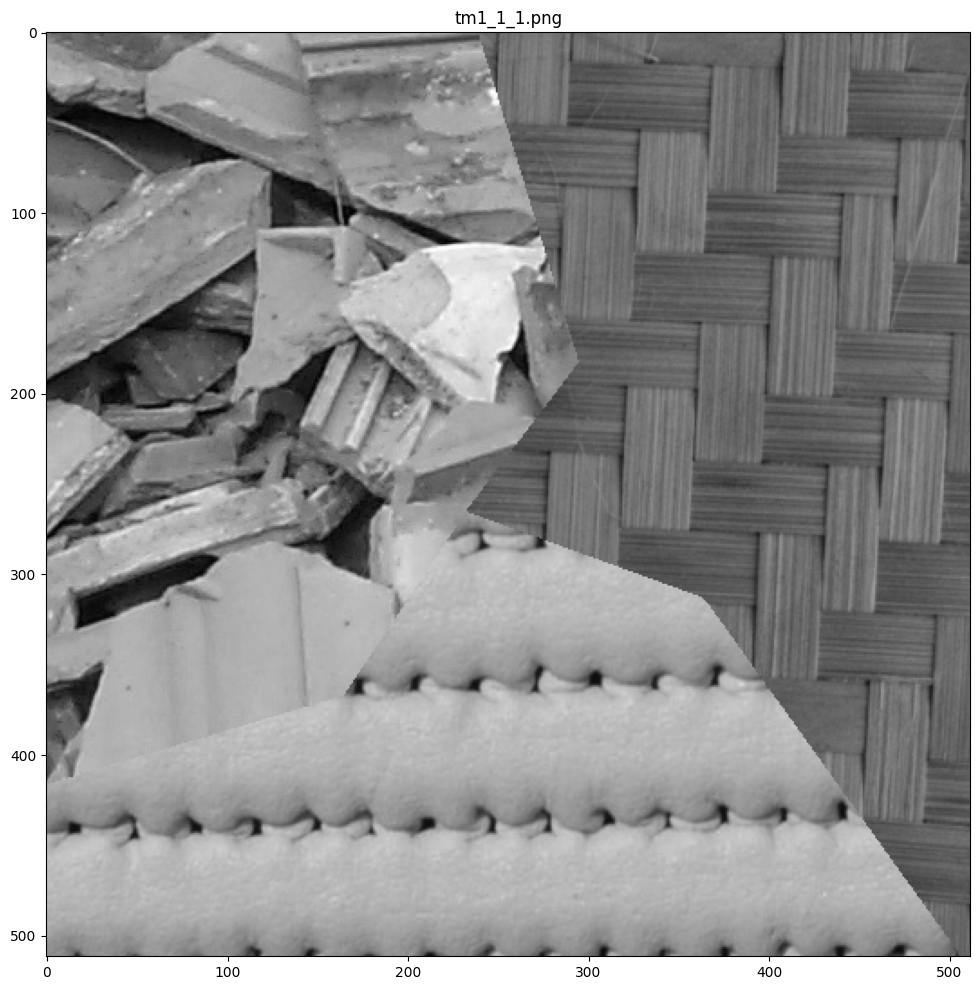

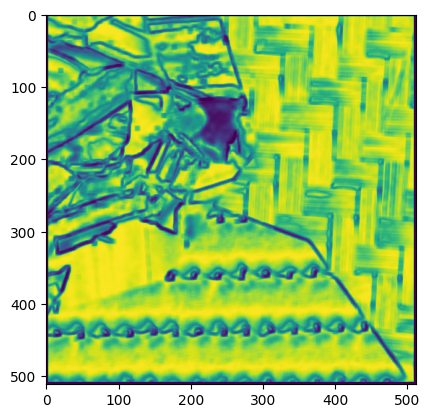

Texture Features Statistics:
Min value: 0.0
Max value: 0.998817185896768
Mean value: 0.7322296047812082
All zeros: False
uint8
uint8


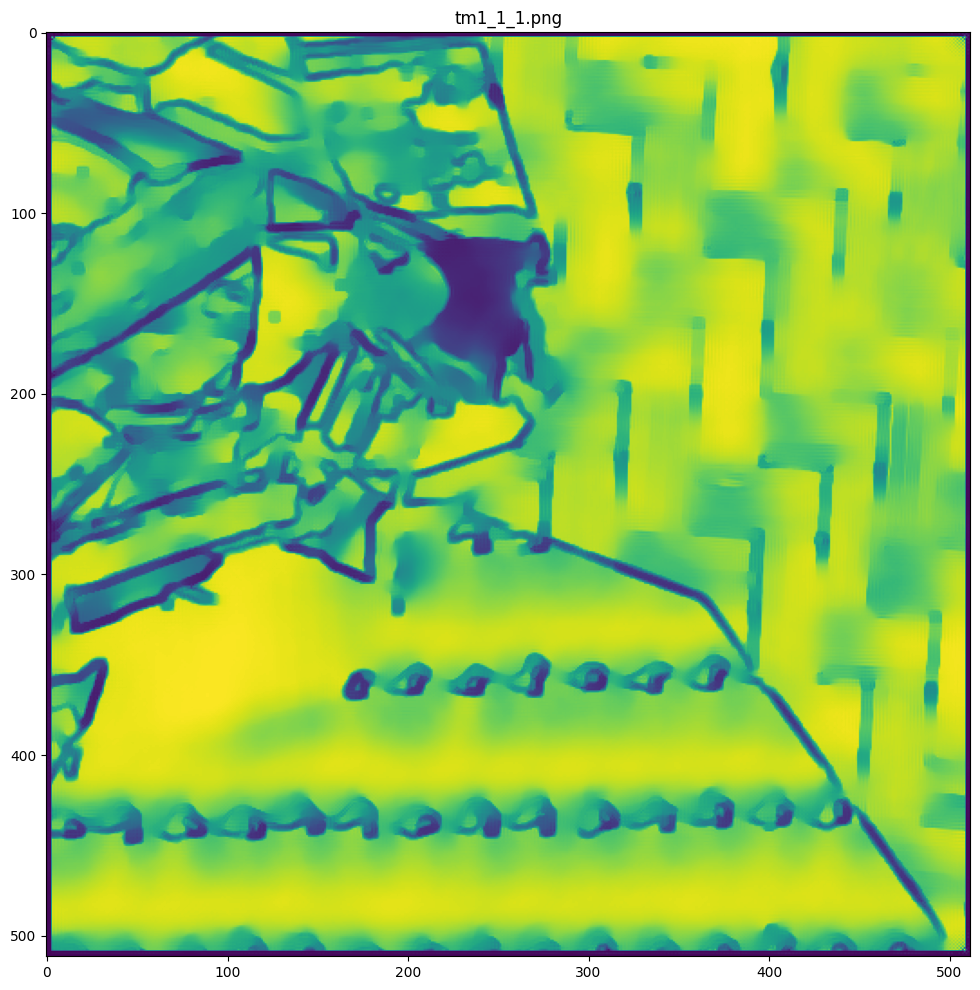

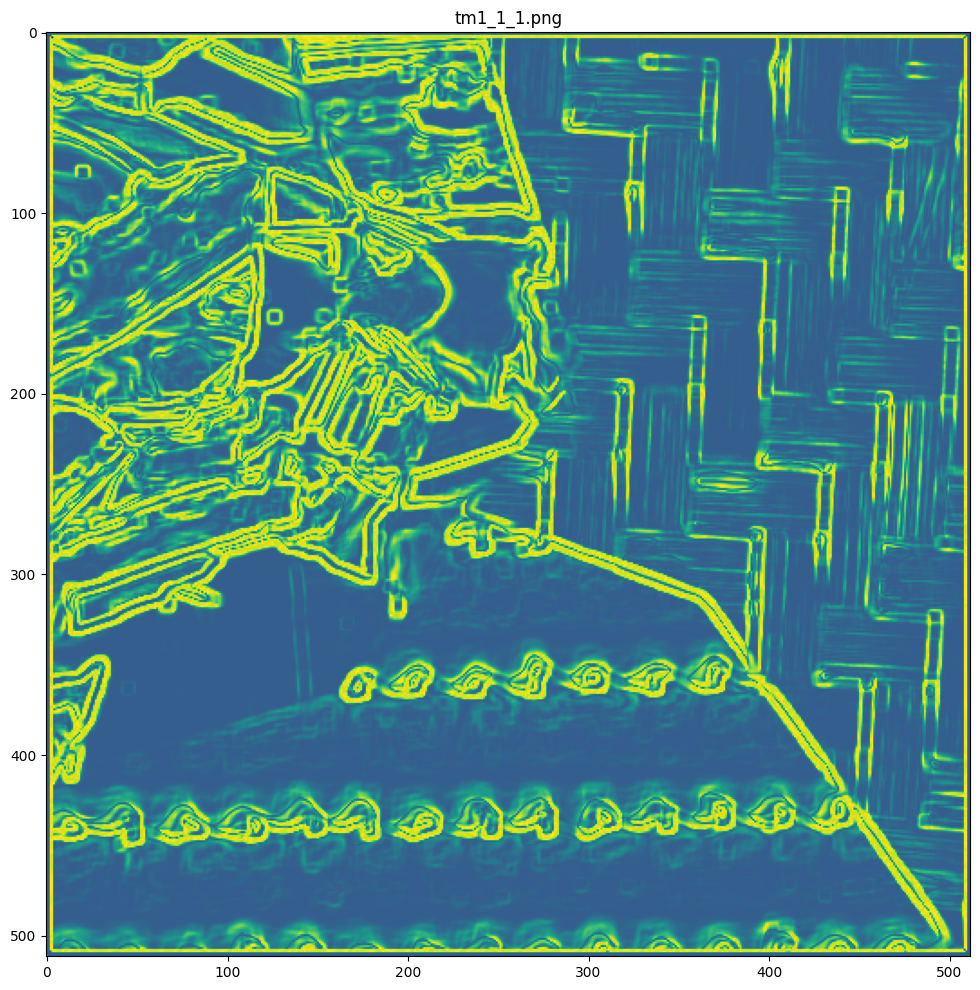

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


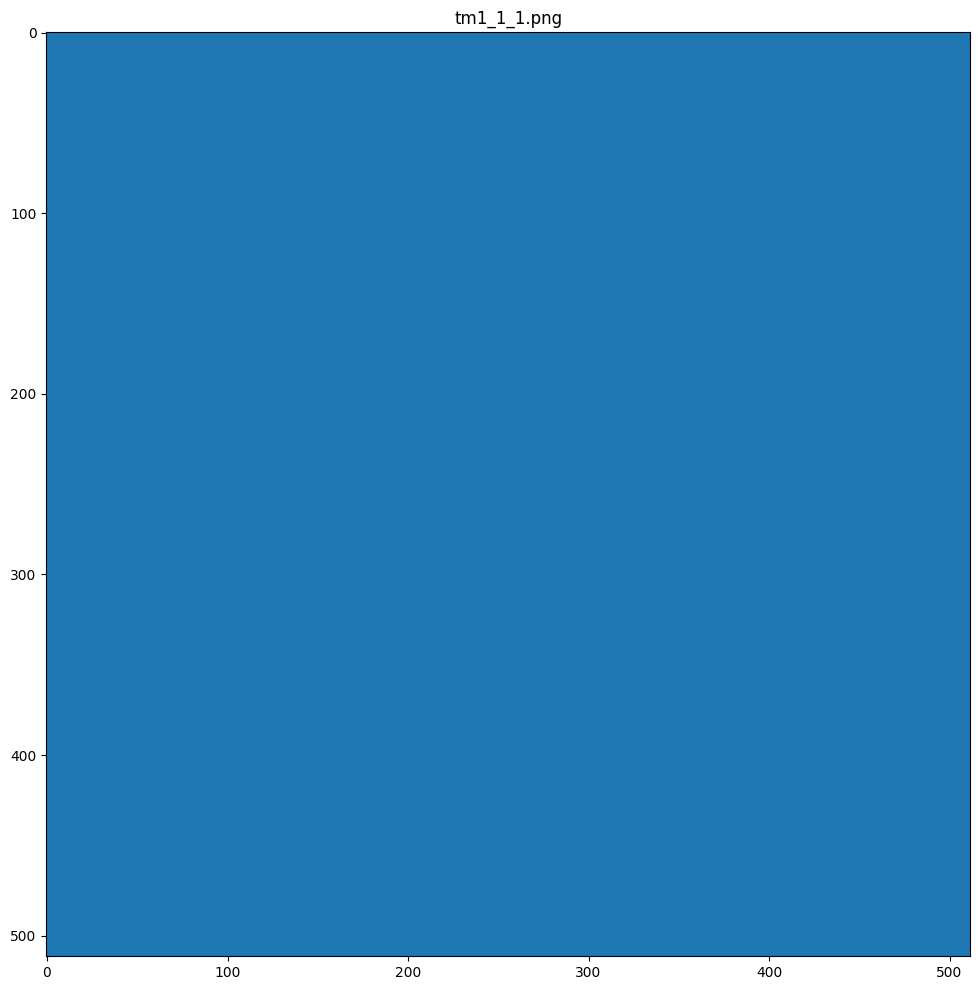

In [98]:
def main(directory):
    images: dict = TextureSegmentation.load_images(directory)
    TextureSegmentation.show_images(images, rows=1, cols=1, cmap='gray')

    patches = dict()
    patch_size = (7, 7)
    resize_shape = None
    for key, image in images.items():
        images[key], patches[key] = TextureSegmentation.preprocess_image(image, patch_size=patch_size, resize_shape=resize_shape)

    # TextureSegmentation.show_images(images, rows=1, cols=2, cmap='gray')
    # print(images)
    # print(patches)
    max_clusters = 3
    prp_centroids = TextureSegmentation.cluster_patches(patches, max_clusters=max_clusters)
    # print(prp_centroids)

    sigma = 0.7
    segmented_images, edges, labels = dict(), dict(), dict()
    iterations = 1
    for key, image in images.items():
        segmented_images[key], edges[key], labels[key] = TextureSegmentation.segmentation(image, prp_centroids,
                                                                             patch_size, sigma, iterations)

    TextureSegmentation.show_images(segmented_images, rows=1, cols=1, cmap=None)
    TextureSegmentation.show_images(edges, rows=1, cols=1, cmap=None)
    print(labels['tm1_1_1.png'])
    TextureSegmentation.show_images(labels, rows=1, cols=1, cmap='tab20')


#     # TextureSegmantation.save_segmented_images('output', {})


if __name__ == '__main__':
    directory = 'data/'
    main(directory)